## 이 노드의 루브릭       

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.       
: 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.   


2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.      
: U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.         


3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.             
: 10Epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞는 품질을 확인하였다.

---
## 프로젝트 수행        

__필수 수행 요건__        

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.      
2. U-Net Generator를 사용해주세요.        
3. 모델 학습 후, val 폴더 내 이미지로 테스트를 진행하세요.      
4. 1개 이상의 이미지에 대해 테스트를 거친 후, 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화 해 주세요.      
5. 10Epoch 이상의 학습을 수행하고, 중간 손실 값에 대한 로그를 남겨주세요.

---           
## 목차             

1. 데이터 로드하기       
2. 데이터 전처리하기      
3. Generator 구성하기         
4. Discriminator 구성하기        
5. 학습하기      
6. 테스트하기

## 1. 데이터 로드하기          

- 다음과 같은 city 사진을 이용해 pix2pix를 활용한 도로 사진을 생성해보자.       

![데이터셋사진](./PostingPic/데이터셋사진.png)

In [12]:
import os

data_path = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes'
train_path = data_path + '/train' 
val_path = data_path + '/val'

print('데이터 경로 : ', data_path)
print('학습 데이터 수 : ' , len(list(os.listdir(train_path))))
print('검증 데이터 수 : ' , len(list(os.listdir(val_path))))

데이터 경로 :  /home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes
학습 데이터 수 :  1000
검증 데이터 수 :  5


#### 데이터 확인하기 

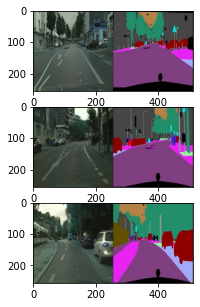

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

for i in range(1, 4):
    f = train_path + "/" +os.listdir(train_path)[np.random.randint(500)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,1,i)
    plt.imshow(img)

> 데이터를 시각화하여 확인하였다.    
> 단, 위의 데이터를 보면 실제 도로 사진과 세그멘테이션 된 도로 사진이 존재하므로, 
위의 사진을 절반 잘라 분리하여야 함을 알 수 있다.

#### 자르기 위해 데이터셋 이미지 크기 확인

In [23]:
f = train_path + "/" + os.listdir(train_path)[0]

img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> 256*512 사이즈의 컬러(3채널) 이미지임을 확인하였고, 가로 너비를 절반 잘라     
> 색깔로 표시된 부분을 input으로 넣어 왼쪽 실사 도로사진 output을 얻겠다.

In [73]:
#필요한 함수 세팅
import tensorflow as tf

#컬러 채널을 노말라이즈
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) -1

#노말라이즈된 채널을 다시 복원
def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

#이미지를 리얼/컬러로 나누어서 노말라이징하여 반환
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1]//2
    real = img[:, :w, :]
    real = tf.cast(real, tf.float32)
    
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    
    return normalize(colored), normalize(real)

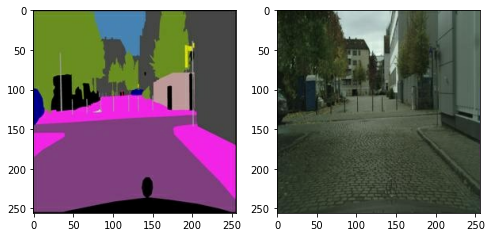

In [74]:
#실제 train_path를 활용하여 하나의 이미지만 절반 잘라보기
f = train_path + "/" + os.listdir(train_path)[1]
real, colored = load_image(f)

plt.figure(figsize=(8,5))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

> 잘 잘라졌음을 확인하였다!

### 조건 1. Augmentation 적용하기

In [75]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(real, colored):
    stacked = tf.concat([real, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    if tf.random.uniform(())<.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
        
    #가로세로(256,512,3)이었던 그림을 절반으로 잘랐기 때문에
    #가로세로(256,256,3)의 그림으로 바뀌었고, 이것을 크롭한다.
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
        
    #아까 합쳐두었던 real과 colored를 다시 3채널 3채널로 나누어 반환
    return out[..., :3], out[..., 3:]

##### 이미지에 augmentation를 적용하여 시각화 해 보자.

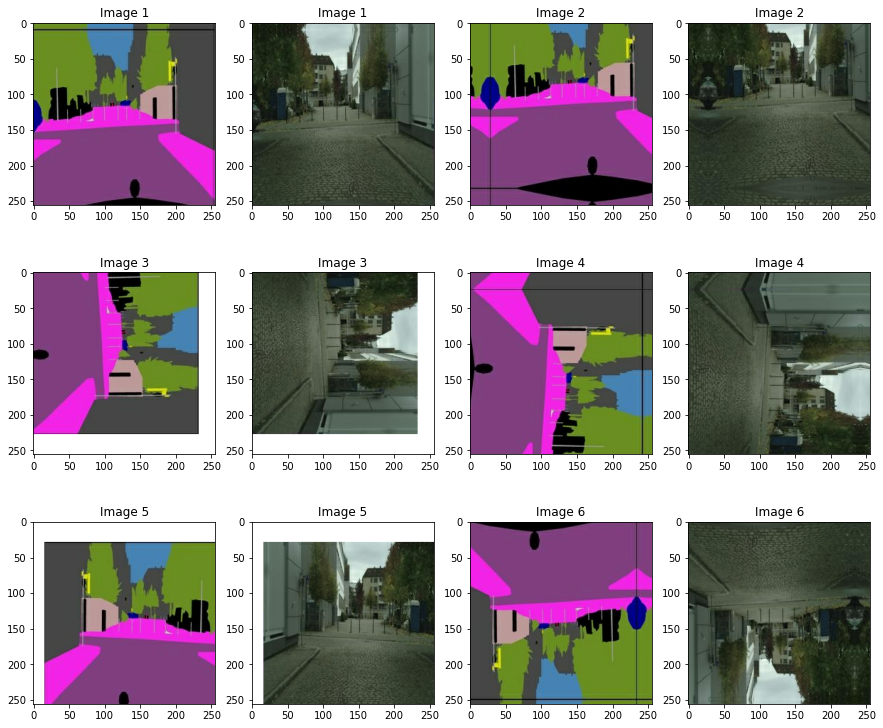

In [76]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_real, augmented_colored = apply_augmentation(real, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1                               

> 이미지에 다양한 augmentation 기법을 적용하였음을 확인하였다.

#### augmentation을 활용한 train_set 만들기

In [77]:
from tensorflow import data

def get_train(img_path):
    real, colored = load_image(img_path)
    real, colored = apply_augmentation(real, colored)
    return real, colored

In [78]:
train_path = data_path + '/train/' 
print(train_path)

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

/home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes/train/


## 2. 생성자 구성하기       

- U-NET 기반의 Generator를 정의하여 사용한다.

In [79]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        
        #배치노말라이제이션을 사용하는 층에면 batchnorm 적용할 수 있도록 조건
        if self.use_bn:
            x = self.batchnorm(x)
            
        return self.lrelu(x)

In [80]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        
        if self.dropout:
            x = layers.Dropout(0.5)(x)
            
        return self.relu(x)

## 조건 2. U-Net 기반의 Generator 사용하기

In [81]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [82]:
# 모델 서머리를 통해 파라미터를 확인해보자.
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_40 (EncodeBlock)   (None, 128, 128, 64) 3072        input_6[0][0]                    
__________________________________________________________________________________________________
encode_block_41 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_40[0][0]            
__________________________________________________________________________________________________
encode_block_42 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_41[0][0]            
____________________________________________________________________________________________

## 3. 판별자 구성하기

In [83]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [84]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [85]:
#판별자도 서머리로 확인해보기!
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]       

## 4. 학습하기              

- 10Epoch 이상의 학습을 수행하고, 중간 손실 값에 대한 로그를 남겨본다.

In [86]:
#실습에서도 활용했듯이, 가장 효과적으로 이미지를 생성하는 GAN손실함수+L1 손실함수를 사용한다.
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [87]:
#optimizer는 실습과 동일(논문과 동일)하게 설정
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

#### 학습 스텝 정의

In [88]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        # 생성자 예측
        fake_colored = generator(sketch, training=True)
        
        # 판별자 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # 생성자 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # 판별자 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

## 조건 3 : 10회 학습 진행, 중간 손실 값에 대한 로그

In [89]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (real, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(real, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8590                     
L1_loss:0.3608                     
Discriminator_loss:1.3056

EPOCH[1] - STEP[20]                     
Generator_loss:0.9680                     
L1_loss:0.2143                     
Discriminator_loss:1.2573

EPOCH[1] - STEP[30]                     
Generator_loss:0.7795                     
L1_loss:0.2694                     
Discriminator_loss:1.3255

EPOCH[1] - STEP[40]                     
Generator_loss:0.7273                     
L1_loss:0.2079                     
Discriminator_loss:1.3117

EPOCH[1] - STEP[50]                     
Generator_loss:0.8980                     
L1_loss:0.2259                     
Discriminator_loss:1.1231

EPOCH[1] - STEP[60]                     
Generator_loss:1.0456                     
L1_loss:0.1847                     
Discriminator_loss:1.0468

EPOCH[1] - STEP[70]                     
Generator_loss:0.8171                     
L1_loss:0.1463                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.9034                     
L1_loss:0.1833                     
Discriminator_loss:1.0000

EPOCH[3] - STEP[80]                     
Generator_loss:2.6240                     
L1_loss:0.2143                     
Discriminator_loss:0.2158

EPOCH[3] - STEP[90]                     
Generator_loss:2.1572                     
L1_loss:0.1739                     
Discriminator_loss:0.6047

EPOCH[3] - STEP[100]                     
Generator_loss:0.4787                     
L1_loss:0.1333                     
Discriminator_loss:1.5279

EPOCH[3] - STEP[110]                     
Generator_loss:1.7748                     
L1_loss:0.1688                     
Discriminator_loss:0.8147

EPOCH[3] - STEP[120]                     
Generator_loss:1.2189                     
L1_loss:0.1960                     
Discriminator_loss:0.7843

EPOCH[3] - STEP[130]                     
Generator_loss:2.9224                     
L1_loss:0.1809                

EPOCH[5] - STEP[130]                     
Generator_loss:0.6392                     
L1_loss:0.1807                     
Discriminator_loss:1.0311

EPOCH[5] - STEP[140]                     
Generator_loss:1.0849                     
L1_loss:0.2031                     
Discriminator_loss:0.5516

EPOCH[5] - STEP[150]                     
Generator_loss:0.9813                     
L1_loss:0.2025                     
Discriminator_loss:0.7268

EPOCH[5] - STEP[160]                     
Generator_loss:2.5727                     
L1_loss:0.1659                     
Discriminator_loss:0.5202

EPOCH[5] - STEP[170]                     
Generator_loss:1.4149                     
L1_loss:0.2039                     
Discriminator_loss:0.5485

EPOCH[5] - STEP[180]                     
Generator_loss:1.4503                     
L1_loss:0.1736                     
Discriminator_loss:0.4349

EPOCH[5] - STEP[190]                     
Generator_loss:1.1574                     
L1_loss:0.2234             

EPOCH[7] - STEP[190]                     
Generator_loss:1.2239                     
L1_loss:0.1824                     
Discriminator_loss:0.7203

EPOCH[7] - STEP[200]                     
Generator_loss:1.8629                     
L1_loss:0.1624                     
Discriminator_loss:0.7783

EPOCH[7] - STEP[210]                     
Generator_loss:1.0976                     
L1_loss:0.2022                     
Discriminator_loss:1.1681

EPOCH[7] - STEP[220]                     
Generator_loss:2.2670                     
L1_loss:0.1718                     
Discriminator_loss:0.4957

EPOCH[7] - STEP[230]                     
Generator_loss:1.2803                     
L1_loss:0.1746                     
Discriminator_loss:0.4517

EPOCH[7] - STEP[240]                     
Generator_loss:1.7107                     
L1_loss:0.1672                     
Discriminator_loss:0.9289

EPOCH[7] - STEP[250]                     
Generator_loss:0.3001                     
L1_loss:0.1757             

EPOCH[9] - STEP[250]                     
Generator_loss:1.8029                     
L1_loss:0.2435                     
Discriminator_loss:0.2324

EPOCH[10] - STEP[10]                     
Generator_loss:2.3072                     
L1_loss:0.1679                     
Discriminator_loss:1.2110

EPOCH[10] - STEP[20]                     
Generator_loss:0.9356                     
L1_loss:0.1690                     
Discriminator_loss:0.6186

EPOCH[10] - STEP[30]                     
Generator_loss:2.6695                     
L1_loss:0.1645                     
Discriminator_loss:1.3332

EPOCH[10] - STEP[40]                     
Generator_loss:2.5232                     
L1_loss:0.2063                     
Discriminator_loss:0.4362

EPOCH[10] - STEP[50]                     
Generator_loss:0.6524                     
L1_loss:0.1654                     
Discriminator_loss:1.1544

EPOCH[10] - STEP[60]                     
Generator_loss:1.3466                     
L1_loss:0.1893             

## 6. 테스트하기

## 조건 4 : 
- 모델 학습 후, val 폴더 내 이미지로 테스트 하기
- 1개 이상의 이미지에 대해 테스트를 거친 후, 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화 해 주세요.

In [90]:
test_ind = 1

f = val_path + '/' + os.listdir(val_path)[test_ind]
print(f)

#val 이미지를 생성자에 전달하기 위해 전처리
real, colored = load_image(f)

/home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes/val/2.jpg


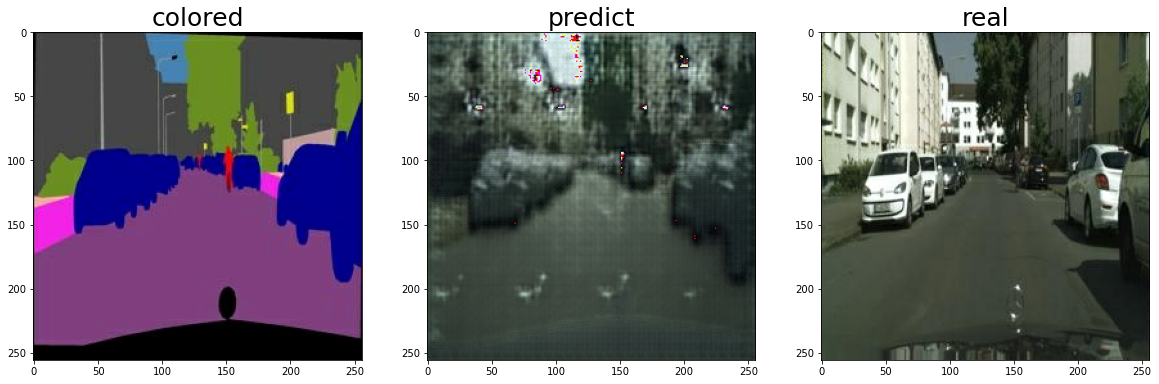

In [96]:
pred = generator(tf.expand_dims(real, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.title("colored", fontsize=25); plt.imshow(denormalize(real))
plt.subplot(1,3,2); plt.title("predict", fontsize=25); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.title("real", fontsize=25); plt.imshow(denormalize(colored))

In [97]:
test_ind = 4

f = val_path + '/' + os.listdir(val_path)[test_ind]
print(f)

#val 이미지를 생성자에 전달하기 위해 전처리
real, colored = load_image(f)

/home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes/val/1.jpg


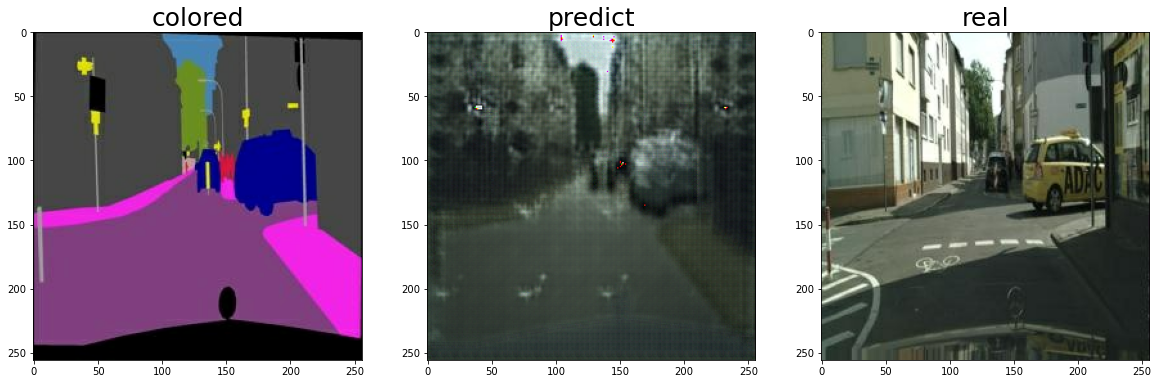

In [98]:
pred = generator(tf.expand_dims(real, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.title("colored", fontsize=25); plt.imshow(denormalize(real))
plt.subplot(1,3,2); plt.title("predict", fontsize=25); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.title("real", fontsize=25); plt.imshow(denormalize(colored))

> 군데군데 칠이 벗겨진 것 같고 흐릿하게 보이지만, 그래도 어느 정도 모양을 갖춘 사진이 생성되었음을 알 수 있다.